## Libraries

In [1]:
import pandas as pd
import numpy as np
from crepes import ConformalClassifier, ConformalPredictiveSystem
from crepes.extras import hinge, margin, binning, DifficultyEstimator

## Data

### Calibration 

In [2]:
data_dir = "calibration_and_test.xlsx" #directory
df_cal=pd.read_excel(data_dir,sheet_name='conf_score_25') #cal dataset with conf=0.25
# df_cal_tp = df_cal[df_cal['TP']==1] # True Positive Predictions Only

# Create a mask where 'gt_obj_id' is '-'
mask = df_cal['gt_obj_id'] == '-'

# Replace the 'gt_obj_id' and 'pred_obj_id' values with 4 where the mask is True
df_cal.loc[mask, 'gt_obj_id'] = 4
df_cal.loc[mask, 'pred_obj_id'] = 4
df_equal = df_cal[df_cal['gt_obj_id'] == df_cal['pred_obj_id']]

df_equal['background_conf_score']= 1 - df_equal['objectness_score']
df_sampled = df_equal

# sample_size = 43

# # Set a seed for the random number generator
# seed = 200

# df_sampled = df_equal.groupby('pred_obj_id').apply(lambda x: x.sample(sample_size, replace=True, random_state=seed))
# df_sampled = df_sampled.reset_index(drop=True)




C:\Users\M\AppData\Local\Temp\ipykernel_29124\2252452809.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_equal['background_conf_score']= 1 - df_equal['objectness_score']


C:\Users\M\AppData\Local\Temp\ipykernel_29124\2383142797.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[conf_score_column] = pd.cut(df_filtered[conf_score_column], bins=np.arange(0, 1.1, 0.1))


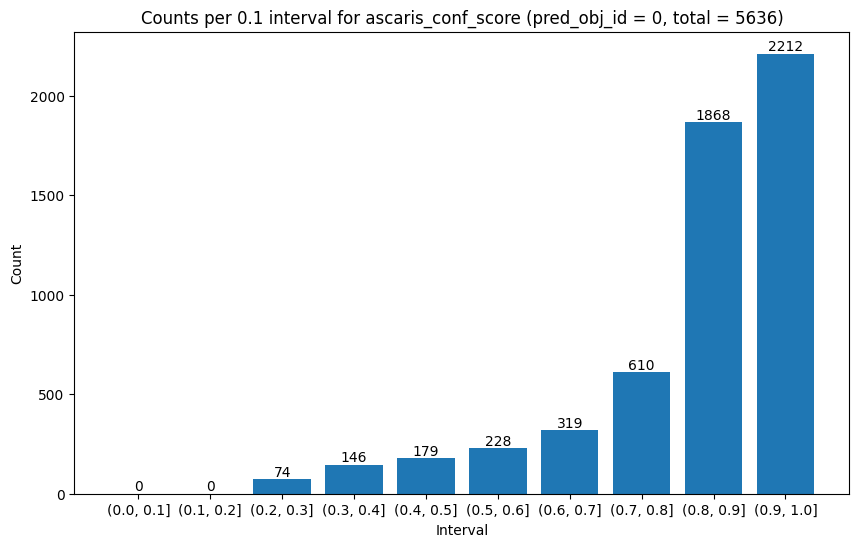

C:\Users\M\AppData\Local\Temp\ipykernel_29124\2383142797.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[conf_score_column] = pd.cut(df_filtered[conf_score_column], bins=np.arange(0, 1.1, 0.1))


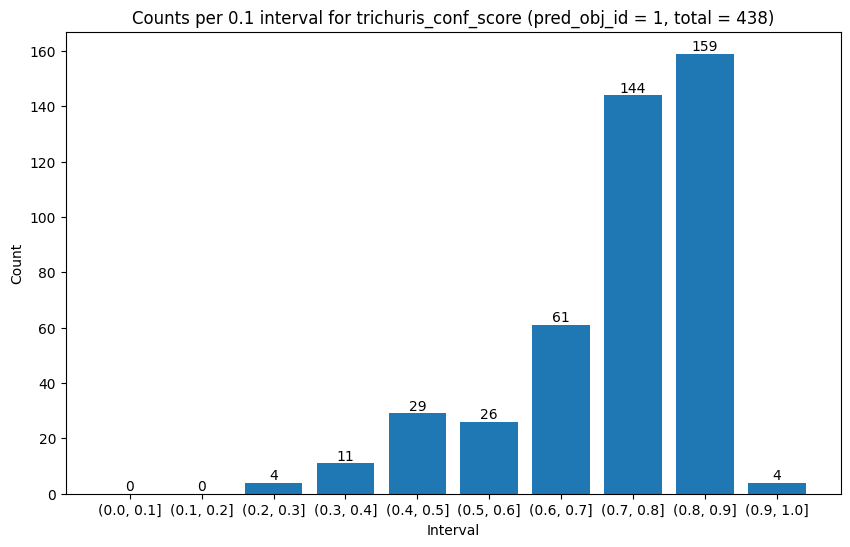

C:\Users\M\AppData\Local\Temp\ipykernel_29124\2383142797.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[conf_score_column] = pd.cut(df_filtered[conf_score_column], bins=np.arange(0, 1.1, 0.1))


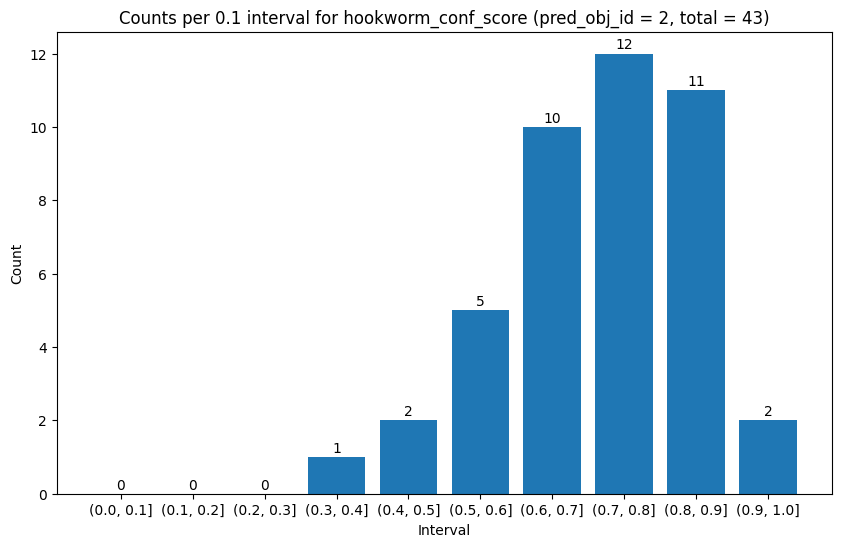

C:\Users\M\AppData\Local\Temp\ipykernel_29124\2383142797.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[conf_score_column] = pd.cut(df_filtered[conf_score_column], bins=np.arange(0, 1.1, 0.1))


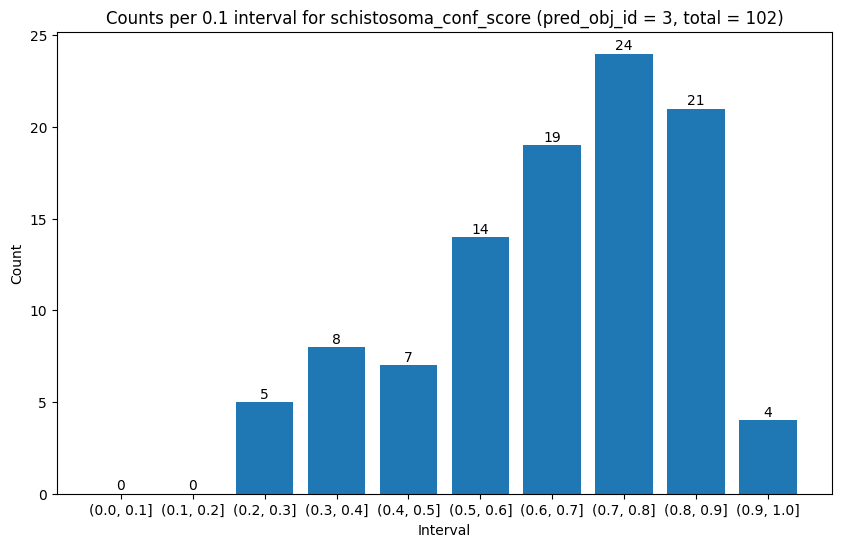

C:\Users\M\AppData\Local\Temp\ipykernel_29124\2383142797.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[conf_score_column] = pd.cut(df_filtered[conf_score_column], bins=np.arange(0, 1.1, 0.1))


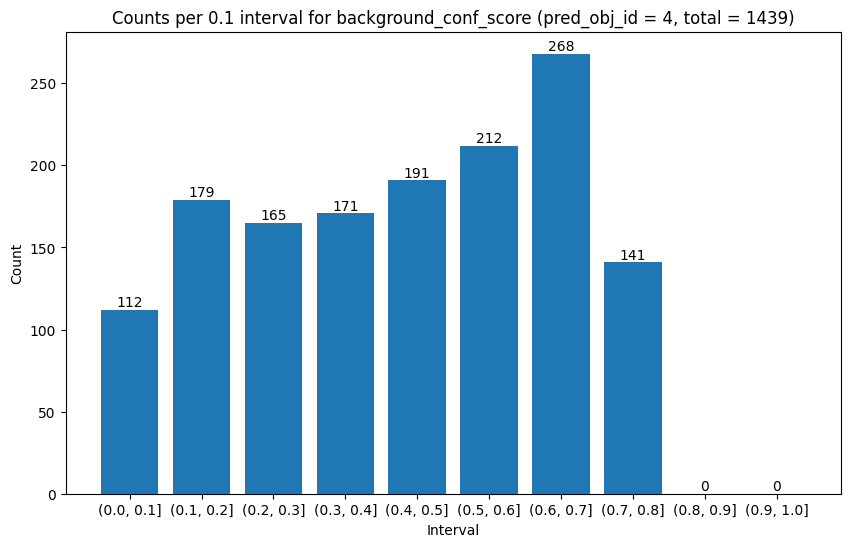

C:\Users\M\AppData\Local\Temp\ipykernel_29124\2383142797.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[conf_score_column] = pd.cut(df_filtered[conf_score_column], bins=np.arange(0, 1.1, 0.1))


            ascaris_conf_score  trichuris_conf_score  hookworm_conf_score  \
(0.0, 0.1]                   0                     0                    0   
(0.1, 0.2]                   0                     0                    0   
(0.2, 0.3]                  74                     4                    0   
(0.3, 0.4]                 146                    11                    1   
(0.4, 0.5]                 179                    29                    2   
(0.5, 0.6]                 228                    26                    5   
(0.6, 0.7]                 319                    61                   10   
(0.7, 0.8]                 610                   144                   12   
(0.8, 0.9]                1868                   159                   11   
(0.9, 1.0]                2212                     4                    2   

            schistosoma_conf_score  background_conf_score  
(0.0, 0.1]                       0                    112  
(0.1, 0.2]                      

In [4]:

import matplotlib.pyplot as plt

# Define the mapping between 'pred_obj_id' and the corresponding confidence score column
mapping = {0: 'ascaris_conf_score', 1: 'trichuris_conf_score', 2: 'hookworm_conf_score', 3: 'schistosoma_conf_score', 4: 'background_conf_score'}

# Loop over the mapping
for pred_obj_id, conf_score_column in mapping.items():
    # Filter the DataFrame by 'pred_obj_id'
    df_filtered = df_equal[df_equal['pred_obj_id'] == pred_obj_id]
    
    # Categorize the data into 0.1 intervals
    df_filtered[conf_score_column] = pd.cut(df_filtered[conf_score_column], bins=np.arange(0, 1.1, 0.1))
    
    # Count the number of occurrences in each interval
    counts = df_filtered[conf_score_column].value_counts().sort_index()
    
    # Calculate the total count
    total_count = counts.sum()
    
    # Create a bar plot of the counts
    plt.figure(figsize=(10, 6))
    bars = plt.bar(counts.index.astype(str), counts.values)
    plt.xlabel('Interval')
    plt.ylabel('Count')
    plt.title(f'Counts per 0.1 interval for {conf_score_column} (pred_obj_id = {pred_obj_id}, total = {total_count})')
    
    # Add the counts on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')
    
    plt.show()

import pandas as pd

# Define the mapping between 'pred_obj_id' and the corresponding confidence score column
mapping = {0: 'ascaris_conf_score', 1: 'trichuris_conf_score', 2: 'hookworm_conf_score', 3: 'schistosoma_conf_score', 4: 'background_conf_score'}

# Create an empty DataFrame to store the distribution
distribution_df = pd.DataFrame()

# Loop over the mapping
for pred_obj_id, conf_score_column in mapping.items():
    # Filter the DataFrame by 'pred_obj_id'
    df_filtered = df_equal[df_equal['pred_obj_id'] == pred_obj_id]
    
    # Categorize the data into 0.1 intervals
    df_filtered[conf_score_column] = pd.cut(df_filtered[conf_score_column], bins=np.arange(0, 1.1, 0.1))
    
    # Count the number of occurrences in each interval
    counts = df_filtered[conf_score_column].value_counts().sort_index()
    
    # Add the counts to the distribution DataFrame
    distribution_df[conf_score_column] = counts

# Print the distribution DataFrame
print(distribution_df)


In [5]:
df_test=pd.read_excel(data_dir,sheet_name='test_conf_score_25') #test dataset with conf=0.25
df_test_filtered = df_test[df_test['pred_obj_id'] != '-']
df_calibration=df_sampled
df_testing=df_test_filtered

df_testing['background_conf_score']= 1 - df_testing['objectness_score']

mask = df_testing['gt_obj_id'] == '-'

# Replace the 'gt_obj_id' and 'pred_obj_id' values with 4 where the mask is True
df_testing.loc[mask, 'gt_obj_id'] = 4
df_testing.loc[mask, 'pred_obj_id'] = 4

C:\Users\M\AppData\Local\Temp\ipykernel_29124\3593833603.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testing['background_conf_score']= 1 - df_testing['objectness_score']
C:\Users\M\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [99]:
df_testing['gt_obj_id'].unique()

array([3, 0, 4, 2, 1], dtype=object)

In [6]:
from my_functions import (softmax, 
                          softmax_df, 
                          calculate_logit, 
                          calculate_sigmoid, 
                          calculate_softmax,
                          calculate_hinge_scores,
                          calculate_p_values,
                          calculate_prediction_sets)

## Calibration stage

In [7]:
alphas_cal = hinge(
    df_sampled[[
        'ascaris_conf_score',
        'trichuris_conf_score',
        'hookworm_conf_score',
        'schistosoma_conf_score',
        'background_conf_score']].values,
    [0,1,2,3,4],df_sampled[['pred_obj_id']].values
)
cc_std = ConformalClassifier()
cc_std.fit(alphas_cal)
display(cc_std)

ConformalClassifier(fitted=True, mondrian=False)

## Testing stage

### Applying the hinge on the testing dataset

In [8]:
conf_score_columns = [
    'ascaris_conf_score',
    'trichuris_conf_score',
    'hookworm_conf_score',
    'schistosoma_conf_score',
    'background_conf_score']
hinge_score_cols = [
    'ascaris_hinge_score', 
    'trichuris_hinge_score', 
    'hookworm_hinge_score', 
    'schistosoma_hinge_score',
    'background_hinge_score']
df_testing = calculate_hinge_scores(
    df_testing, 
    conf_score_columns, 
    hinge_score_cols)

C:\Users\M\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [9]:
p_value_cols = [
    'ascaris_p_value', 
    'trichuris_p_value', 
    'hookworm_p_value', 
    'schistosoma_p_value',
    'background_p_value']
df_testing = calculate_p_values(
    df_testing, 
    hinge_score_cols, 
    p_value_cols, 
    cc_std)

C:\Users\M\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [10]:
p_set_cols = [
    'ascaris_p_set', 
    'trichuris_p_set', 
    'hookworm_p_set', 
    'schistosoma_p_set',
    'background_p_set']
df_testing = calculate_prediction_sets(
    df_testing, 
    hinge_score_cols, 
    p_set_cols, 
    cc_std,
    confidence=0.99)

In [11]:
non_confirmity_scores = df_testing[df_testing['gt_obj_id']!='-'][['ascaris_hinge_score', 
                                                                  'trichuris_hinge_score', 
                                                                  'hookworm_hinge_score', 
                                                                  'schistosoma_hinge_score',
                                                                  'background_hinge_score']].values
non_confirmity_scores = non_confirmity_scores.astype(np.float64)
classes = [0,1,2,3,4]
y_test = df_testing[df_testing['gt_obj_id']!= '-']['gt_obj_id'].values
y_test = y_test.astype(np.int64)
cc_std.evaluate(non_confirmity_scores,classes, y_test, metrics=['error','avg_c','one_c','empty'])

{'error': 0.02678088367899012,
 'avg_c': 1.251668169522092,
 'one_c': 0.7508566275924257,
 'empty': 0.0}

### 1. Singleton TPs

In [12]:
# Filter out '-' class
df_testing_filtered = df_testing[df_testing['gt_obj_id'] != '-']

# Calculate counts
gt_counts = df_testing_filtered['gt_obj_id'].value_counts()
pred_counts = df_testing_filtered['pred_obj_id'].value_counts()

# Create a mask where each value is True if the corresponding value in p_set_cols is 1
mask = (df_testing[p_set_cols] == 1)

# Sum the True values along the rows. This gives the number of 1s in each row.
one_counts = mask.sum(axis=1)

# Create a mask where each value is True if the corresponding value in one_counts is 1 (singleton) and gt_obj_id matches pred_obj_id
mask_singleton_tp = (one_counts == 1) & (df_testing['gt_obj_id'] == df_testing['pred_obj_id'])

# Use the mask to filter the DataFrame
df_singleton_tp = df_testing[mask_singleton_tp]
singleton_counts = df_singleton_tp['gt_obj_id'].value_counts()

# For non-singleton sets, we want rows where the sum of 1s is more than 1
mask_non_singleton = (one_counts > 1) & (df_testing['gt_obj_id'] == df_testing['pred_obj_id'])
df_non_singleton_tp = df_testing[mask_non_singleton]
non_singleton_counts = df_non_singleton_tp['gt_obj_id'].value_counts()

# For empty sets, we want rows where the sum of 1s is 0
mask_empty_set = (one_counts == 0) & (df_testing['gt_obj_id'] == df_testing['pred_obj_id'])
df_empty_set_tp = df_testing[mask_empty_set]
empty_set_counts = df_empty_set_tp['gt_obj_id'].value_counts()

# Convert to DataFrame and merge
gt_counts_df = gt_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'GT Counts'})
pred_counts_df = pred_counts.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Pred Counts'})
singleton_counts_df = singleton_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Singleton Counts'})
non_singleton_counts_df = non_singleton_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Non-Singleton Counts'})
empty_set_counts_df = empty_set_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Empty Set Counts'})

counts_df = pd.merge(gt_counts_df, pred_counts_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, singleton_counts_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, non_singleton_counts_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, empty_set_counts_df, on='Class', how='outer')

# Create a mapping dictionary
class_mapping = {0: 'ascaris', 1: 'trichuris', 2: 'hookworm', 3: 'schistosoma', 4: 'background'}

# Replace numeric class labels with string labels
counts_df['Class'] = counts_df['Class'].replace(class_mapping)

counts_df

,Class,GT Counts,Pred Counts,Singleton Counts,Non-Singleton Counts,Empty Set Counts
0,ascaris,8915,8970,2556.0,6328,NaN
1,background,1468,1468,12.0,1456,NaN
2,trichuris,523,468,3.0,463,NaN
3,schistosoma,133,136,6.0,125,NaN
4,hookworm,51,48,NaN,19,NaN


## FNs

In [13]:
# Filter out '-' class and create a new DataFrame
df_filtered = df_testing[df_testing['gt_obj_id'] != '-']

# Calculate counts
gt_counts = df_filtered['gt_obj_id'].value_counts()
pred_counts = df_filtered['pred_obj_id'].value_counts()

# Create a mask where each value is True if the corresponding value in p_set_cols is 1
mask = (df_filtered[p_set_cols] == 1)

# Sum the True values along the rows. This gives the number of 1s in each row.
one_counts = mask.sum(axis=1)

# Create a mask where each value is True if the corresponding value in one_counts is 1 (singleton) and gt_obj_id does not match pred_obj_id
mask_singleton_fn = (one_counts == 1) & (df_filtered['gt_obj_id'] != df_filtered['pred_obj_id'])

# Use the mask to filter the DataFrame
df_singleton_fn = df_filtered[mask_singleton_fn]
singleton_counts_fn = df_singleton_fn['gt_obj_id'].value_counts()

# For non-singleton sets, we want rows where the sum of 1s is more than 1 and the corresponding class in the set is 0
mask_non_singleton = (one_counts > 1) & ~mask
df_non_singleton_fn = df_filtered[mask_non_singleton]
non_singleton_counts_fn = df_non_singleton_fn['gt_obj_id'].value_counts()

# For empty sets, we want rows where the sum of 1s is 0
mask_empty_set = (one_counts == 0) & (df_filtered['gt_obj_id'] != df_filtered['pred_obj_id'])
df_empty_set_fn = df_filtered[mask_empty_set]
empty_set_counts_fn = df_empty_set_fn['gt_obj_id'].value_counts()

# Convert to DataFrame and merge
gt_counts_df = gt_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'GT Counts'})
pred_counts_df = pred_counts.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Pred Counts'})
singleton_counts_fn_df = singleton_counts_fn.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Singleton FN Counts'})
non_singleton_counts_fn_df = non_singleton_counts_fn.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Non-Singleton FN Counts'})
empty_set_counts_fn_df = empty_set_counts_fn.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Empty Set FN Counts'})

counts_df = pd.merge(gt_counts_df, pred_counts_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, singleton_counts_fn_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, non_singleton_counts_fn_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, empty_set_counts_fn_df, on='Class', how='outer')

# Create a mapping dictionary
class_mapping = {0: 'ascaris', 1: 'trichuris', 2: 'hookworm', 3: 'schistosoma', 4: 'background'}

# Replace numeric class labels with string labels
counts_df['Class'] = counts_df['Class'].replace(class_mapping)

counts_df

,Class,GT Counts,Pred Counts,Singleton FN Counts,Non-Singleton FN Counts,Empty Set FN Counts
0,ascaris,8915,8970,NaN,NaN,NaN
1,background,1468,1468,NaN,NaN,NaN
2,trichuris,523,468,NaN,NaN,NaN
3,schistosoma,133,136,NaN,NaN,NaN
4,hookworm,51,48,NaN,NaN,NaN


In [17]:
df_testing

,filename,image_width,image_height,gt_obj_id,gt_x_center,gt_y_center,gt_obj_width,gt_obj_height,pred_obj_id,pred_x_center,...,ascaris_p_value,trichuris_p_value,hookworm_p_value,schistosoma_p_value,background_p_value,ascaris_p_set,trichuris_p_set,hookworm_p_set,schistosoma_p_set,background_p_set
0,11184288_1608_36_af7b24d7-fd97-42a0-acc9-1b7a9...,1280,720,3,0.9605,0.6972,0.0773,0.1583,3,0.961328,...,0.000061,0.000083,9.849216e-06,0.233696,0.111932,0,0,0,1,1
1,11184288_1608_36_af7b24d7-fd97-42a0-acc9-1b7a9...,1280,720,0,0.4059,0.4347,0.0586,0.1278,2,0.406641,...,0.000007,0.048974,1.081574e-01,0.000048,0.082905,0,1,1,0,1
2,11184288_1608_36_af7b24d7-fd97-42a0-acc9-1b7a9...,1280,720,4,-,-,-,-,4,0.405078,...,0.000097,0.191534,4.896966e-02,0.000001,0.044318,0,1,1,0,1
3,11184394_1608_36_af7b24d7-fd97-42a0-acc9-1b7a9...,1280,720,3,0.1703,0.7111,0.0984,0.125,3,0.16875,...,0.000003,0.000099,4.382177e-07,0.346256,0.060990,0,0,0,1,1
4,11184394_1608_36_af7b24d7-fd97-42a0-acc9-1b7a9...,1280,720,4,-,-,-,-,4,0.692187,...,0.371921,0.000053,8.030452e-05,0.000121,0.052652,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11869,9354474_1379_31_75602595-167c-4758-8f96-e8ee5e...,1280,720,0,0.6988,0.5833,0.0602,0.0833,0,0.698828,...,0.671121,0.000004,7.399395e-05,0.000023,0.016410,1,0,0,0,1
11870,9354474_1379_31_75602595-167c-4758-8f96-e8ee5e...,1280,720,0,0.4684,0.2347,0.0586,0.1028,0,0.46875,...,0.932075,0.000047,7.744075e-05,0.000122,0.003109,1,0,0,0,0
11871,9357486_1384_31_941af06b-54a3-4552-b75f-4e6e72...,1280,720,0,0.0187,0.7007,0.0375,0.0958,0,0.019141,...,0.497354,0.000118,1.117577e-04,0.000065,0.028215,1,0,0,0,1
11873,9419118_1393_31_55d950b3-e8d5-48b7-b7a7-30014f...,1280,720,4,-,-,-,-,4,0.970312,...,0.000104,0.000075,1.146137e-02,0.122366,0.207988,0,0,1,1,1


In [19]:
df_testing[['ascaris_conf_score','trichuris_conf_score','hookworm_conf_score','schistosoma_conf_score','background_conf_score']]

,ascaris_conf_score,trichuris_conf_score,hookworm_conf_score,schistosoma_conf_score,background_conf_score
0,0.00016,0.001084,0.002551,0.604113,0.395766
1,0.008644,0.246102,0.386542,0.009769,0.327184
2,0.002575,0.539015,0.246167,0.015390,0.223441
3,0.001299,0.000677,0.003993,0.721616,0.27797
4,0.742962,0.001392,0.002313,0.000662,0.25615
...,...,...,...,...,...
11869,0.892878,0.000541,0.003116,0.000910,0.106285
11870,0.931859,0.000398,0.006069,0.001678,0.067193
11871,0.832784,0.001799,0.006972,0.006429,0.161322
11873,0.003763,0.000506,0.088541,0.415351,0.565018


## FPs


In [14]:
# Filter out '-' class
df_filtered = df_testing[df_testing['gt_obj_id'] != '-']

# Calculate counts
gt_counts = df_filtered['gt_obj_id'].value_counts()
pred_counts = df_filtered['pred_obj_id'].value_counts()

# Create a mask where each value is True if the corresponding value in p_set_cols is 1
mask = (df_filtered[p_set_cols] == 1)

# Sum the True values along the rows. This gives the number of 1s in each row.
one_counts = mask.sum(axis=1)

# Create a mask where each value is True if the corresponding value in one_counts is 1 (singleton) and gt_obj_id does not match pred_obj_id
mask_singleton_fp = (one_counts == 1) & (df_filtered['gt_obj_id'] != df_filtered['pred_obj_id'])

# Use the mask to filter the DataFrame
df_singleton_fp = df_filtered[mask_singleton_fp]
singleton_counts_fp = df_singleton_fp['pred_obj_id'].value_counts()

# For non-singleton sets, we want rows where the sum of 1s is more than 1 and the corresponding class in the set is 0
mask_non_singleton = (one_counts > 1) & ~mask
df_non_singleton_fp = df_filtered[mask_non_singleton]
non_singleton_counts_fp = df_non_singleton_fp['pred_obj_id'].value_counts()

# For empty sets, we want rows where the sum of 1s is 0
mask_empty_set = (one_counts == 0) & (df_filtered['gt_obj_id'] != df_filtered['pred_obj_id'])
df_empty_set_fp = df_filtered[mask_empty_set]
empty_set_counts_fp = df_empty_set_fp['pred_obj_id'].value_counts()

# Convert to DataFrame and merge
gt_counts_df = gt_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'GT Counts'})
pred_counts_df = pred_counts.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Pred Counts'})
singleton_counts_fp_df = singleton_counts_fp.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Singleton FP Counts'})
non_singleton_counts_fp_df = non_singleton_counts_fp.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Non-Singleton FP Counts'})
empty_set_counts_fp_df = empty_set_counts_fp.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Empty Set FP Counts'})

counts_df = pd.merge(gt_counts_df, pred_counts_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, singleton_counts_fp_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, non_singleton_counts_fp_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, empty_set_counts_fp_df, on='Class', how='outer')

# Create a mapping dictionary
class_mapping = {0: 'ascaris', 1: 'trichuris', 2: 'hookworm', 3: 'schistosoma'}

# Replace numeric class labels with string labels
counts_df['Class'] = counts_df['Class'].replace(class_mapping)

counts_df

,Class,GT Counts,Pred Counts,Singleton FP Counts,Non-Singleton FP Counts,Empty Set FP Counts
0,ascaris,8915,8970,NaN,NaN,NaN
1,4,1468,1468,NaN,NaN,NaN
2,trichuris,523,468,NaN,NaN,NaN
3,schistosoma,133,136,NaN,NaN,NaN
4,hookworm,51,48,NaN,NaN,NaN


In [15]:
# Create a mask where each value is True if gt_obj_id is "-"
mask = (df_testing['gt_obj_id'] == '-')

# Use the mask to filter the DataFrame
df_filtered = df_testing[mask]

def count_sets(df_filtered, p_set_cols, condition, column_name):
    # Create a mask where each value is True if the corresponding value in p_set_cols is 1
    mask = (df_filtered[p_set_cols] == 1)

    # Sum the True values along the rows. This gives the number of 1s in each row.
    one_counts = mask.sum(axis=1)

    # Create a mask based on the condition
    mask_condition = condition(one_counts) & (df_filtered['gt_obj_id'] == '-')

    # Use the mask to filter the DataFrame
    df_condition = df_filtered[mask_condition]

    # Count the sets per class
    condition_counts = df_condition['pred_obj_id'].value_counts()

    # Convert to DataFrame
    condition_counts_df = condition_counts.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': column_name})

    # Create a mapping dictionary
    class_mapping = {0: 'ascaris', 1: 'trichuris', 2: 'hookworm', 3: 'schistosoma'}

    # Replace numeric class labels with string labels
    condition_counts_df['Class'] = condition_counts_df['Class'].replace(class_mapping)

    return condition_counts_df

# Count the singletons, non-singletons, and empty sets per class
singleton_counts_fp_df = count_sets(df_filtered, p_set_cols, lambda x: x == 1, 'Singleton FP Counts')
non_singleton_counts_fp_df = count_sets(df_filtered, p_set_cols, lambda x: x > 1, 'Non-Singleton FP Counts')
empty_set_counts_fp_df = count_sets(df_filtered, p_set_cols, lambda x: x == 0, 'Empty Set FP Counts')

# Merge the three dataframes on 'Class'
merged_df = pd.merge(singleton_counts_fp_df, non_singleton_counts_fp_df, on='Class', how='outer')
merged_df = pd.merge(merged_df, empty_set_counts_fp_df, on='Class', how='outer')

# Fill NaN values with 0
merged_df = merged_df.fillna(0)

# Convert counts to integers
merged_df['Singleton FP Counts'] = merged_df['Singleton FP Counts'].astype(int)
merged_df['Non-Singleton FP Counts'] = merged_df['Non-Singleton FP Counts'].astype(int)
merged_df['Empty Set FP Counts'] = merged_df['Empty Set FP Counts'].astype(int)

merged_df

,Singleton FP Counts,Non-Singleton FP Counts,Class,Empty Set FP Counts


In [94]:
df_testing.to_csv('hinge_seed_100_background.csv',index=False)